### Для начала импортирую необходимые библиотеки. В данной работе я буду использовать 2 алгоритма классификации: XGBClassifier и CatBoostClassifier

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, confusion_matrix
# from pycaret.classification import *
# import pycaret

### Загружаю и читаю первые 5 строк тренировочного и тестового датасетов

In [2]:
df_train = pd.read_excel('Training.xlsb')
df_test = pd.read_excel('Test.xlsb')

In [3]:
df_train.head()

,ID,A,B,C,D,E,F,G,H,I,...,P,Q,R,S,T,U,V,W,X,MARKER
0,1,0.198778,0.099389,0.00,799.90,1.777556,0.888778,13,3.49,Woman,...,2 Two,property,No,Works,Yes,Yes,No,Yes,No,0
1,2,0.043000,0.021264,49.97,173.03,0.384511,0.190143,13,3.49,Woman,...,2 Two,otherwise,No,Works,Yes,Yes,Yes,Yes,No,0
2,3,0.067073,0.067073,0.00,329.90,0.599818,0.599818,13,3.49,Woman,...,1 One,property,No,No couple,No,Yes,No,Yes,No,0
3,4,0.052700,0.052700,0.00,235.65,0.471300,0.471300,13,3.49,Woman,...,0 Zero,property,No,No couple,Yes,Yes,Few,Yes,No,0
4,5,0.141880,0.141880,0.00,634.45,1.268900,1.268900,13,3.49,Woman,...,0 Zero,property,No,No couple,Yes,No,No,No,No,0


In [4]:
df_test.head()

,ID,A,B,C,D,E,F,G,H,I,...,P,Q,R,S,T,U,V,W,X,MARKER
0,1,0.085400,0.085400,29.72,267.28,0.763657,0.763657,13,3.49,Woman,...,1 One,property,No,No couple,Yes,Yes,No,No,No,0
1,2,0.223218,0.111609,0.00,1097.90,1.996182,0.998091,13,3.49,Woman,...,3 Three,property,No,Works,Yes,Yes,No,No,No,1
2,3,0.048400,0.048400,0.00,399.90,0.499875,0.499875,13,1.99,Man,...,0 Zero,property,No,Unemployed,Yes,Yes,No,No,No,0
3,4,0.039560,0.039560,19.59,176.93,0.353860,0.353860,13,3.49,Man,...,1 One,property,No,Unemployed,Yes,Yes,Yes,Yes,No,0
4,5,0.231017,0.173263,0.00,1239.56,2.065933,1.549450,13,3.49,Woman,...,1 One,property,No,Works,Yes,Yes,No,No,No,0


In [5]:
print(f'Train: {df_train.shape}')
print(f'Test: {df_test.shape}')

Train: (89734, 26)
Test: (38405, 26)


### В данных датасетах названия столбцов изначально зашифрованы. Изучу уникальные значения в столбцах с категориальными переменными и попробую дать им названия согласно содержанию

In [6]:
for cat_col in ['I', 'K', 'M', 'N', 'O', 'P', 'Q', 'S']:
    print(cat_col, df_train[cat_col].unique(), sep='\n', end='\n\n')

I
['Woman' 'Man']

K
['Mogilev region' 'Minsk region' 'Vitebsk region' 'Brest region' 'Minsk'
 'Grodno region' 'Gomel region']

M
['NE employee' 'Pensioner' 'Head/Deputy head (organiz.)'
 'Head/Deputy head (division)' 'Enterpreneur']

N
['Secondary education (plus special education)'
 'Higher education (one or more)' 'Incomplete higher education'
 'Primary or lower secondary education']

O
['Married' 'Divorced/widow' 'Single/unmarried' 'Cohabitation']

P
['2 Two' '1 One' '0 Zero' '3 Three' 'More than 3']

Q
['property' 'otherwise' 'rent/hire']

S
['Works' 'No couple' 'Pensioner' 'Unemployed' 'Student']



### Переименовываю столбцы в тренировочном и тестовом датасетах согласно содержанию:

I - Пол;

K - Регион;

M - Название профессии;

N - Образование;

O - Семейное положение;

P - Дети (логическое предположение);

Q - Жилье;

S - Статус занятости.

In [7]:
# 6 - Rename some properties' names
df_train.rename(columns={'I': 'Sex'}, inplace=True)
df_train.rename(columns={'K': 'Region'}, inplace=True)
df_train.rename(columns={'M': 'Job_title'}, inplace=True)
df_train.rename(columns={'N': 'Education'}, inplace=True)
df_train.rename(columns={'O': 'Marriage'}, inplace=True)
df_train.rename(columns={'P': 'Children'}, inplace=True)
df_train.rename(columns={'Q': 'Property'}, inplace=True)
df_train.rename(columns={'S': 'Employment_status'}, inplace=True)

df_test.rename(columns={'I': 'Sex'}, inplace=True)
df_test.rename(columns={'K': 'Region'}, inplace=True)
df_test.rename(columns={'M': 'Job_title'}, inplace=True)
df_test.rename(columns={'N': 'Education'}, inplace=True)
df_test.rename(columns={'O': 'Marriage'}, inplace=True)
df_test.rename(columns={'P': 'Children'}, inplace=True)
df_test.rename(columns={'Q': 'Property'}, inplace=True)
df_test.rename(columns={'S': 'Employment_status'}, inplace=True)

In [8]:
df_train.head()

,ID,A,B,C,D,E,F,G,H,Sex,...,Children,Property,R,Employment_status,T,U,V,W,X,MARKER
0,1,0.198778,0.099389,0.00,799.90,1.777556,0.888778,13,3.49,Woman,...,2 Two,property,No,Works,Yes,Yes,No,Yes,No,0
1,2,0.043000,0.021264,49.97,173.03,0.384511,0.190143,13,3.49,Woman,...,2 Two,otherwise,No,Works,Yes,Yes,Yes,Yes,No,0
2,3,0.067073,0.067073,0.00,329.90,0.599818,0.599818,13,3.49,Woman,...,1 One,property,No,No couple,No,Yes,No,Yes,No,0
3,4,0.052700,0.052700,0.00,235.65,0.471300,0.471300,13,3.49,Woman,...,0 Zero,property,No,No couple,Yes,Yes,Few,Yes,No,0
4,5,0.141880,0.141880,0.00,634.45,1.268900,1.268900,13,3.49,Woman,...,0 Zero,property,No,No couple,Yes,No,No,No,No,0


### Вывожу статистические показатели для столбцов с непрерывными переменными

In [9]:
df_train.describe()

,ID,A,B,C,D,E,F,G,H,J,L,MARKER
count,89734.000000,89734.000000,89734.000000,89734.000000,89734.000000,89734.000000,89734.000000,89734.000000,89734.000000,89734.000000,89734.000000,89734.000000
mean,44867.500000,0.167863,0.113511,85.801266,548.507954,1.011455,0.683640,7.854358,0.510274,41.140778,103.719092,0.003811
std,25904.118865,0.153851,0.105340,105.366771,448.686233,0.910583,0.622047,4.754588,0.928146,11.129976,100.458022,0.061618
min,1.000000,0.000002,0.000001,0.000000,49.980000,0.000016,0.000012,2.000000,0.000000,21.000000,0.000000,0.000000
25%,22434.250000,0.065843,0.042922,20.570000,227.030000,0.405983,0.263775,4.000000,0.000000,32.083333,29.000000,0.000000
50%,44867.500000,0.119133,0.079733,50.020000,408.735000,0.749403,0.499387,5.000000,0.000000,40.000000,69.000000,0.000000
75%,67300.750000,0.220000,0.146990,108.930000,746.710000,1.333367,0.899260,13.000000,0.010000,50.000000,144.000000,0.000000
max,89734.000000,7.067250,0.874025,2682.420000,4999.000000,35.337000,10.352991,24.000000,3.500000,64.916667,540.000000,1.000000


array([[<Axes: title={'center': 'A'}>, <Axes: title={'center': 'B'}>,
        <Axes: title={'center': 'C'}>],
       [<Axes: title={'center': 'D'}>, <Axes: title={'center': 'E'}>,
        <Axes: title={'center': 'F'}>],
       [<Axes: title={'center': 'G'}>, <Axes: title={'center': 'H'}>,
        <Axes: title={'center': 'J'}>],
       [<Axes: title={'center': 'L'}>,
        <Axes: title={'center': 'MARKER'}>, <Axes: >]], dtype=object)

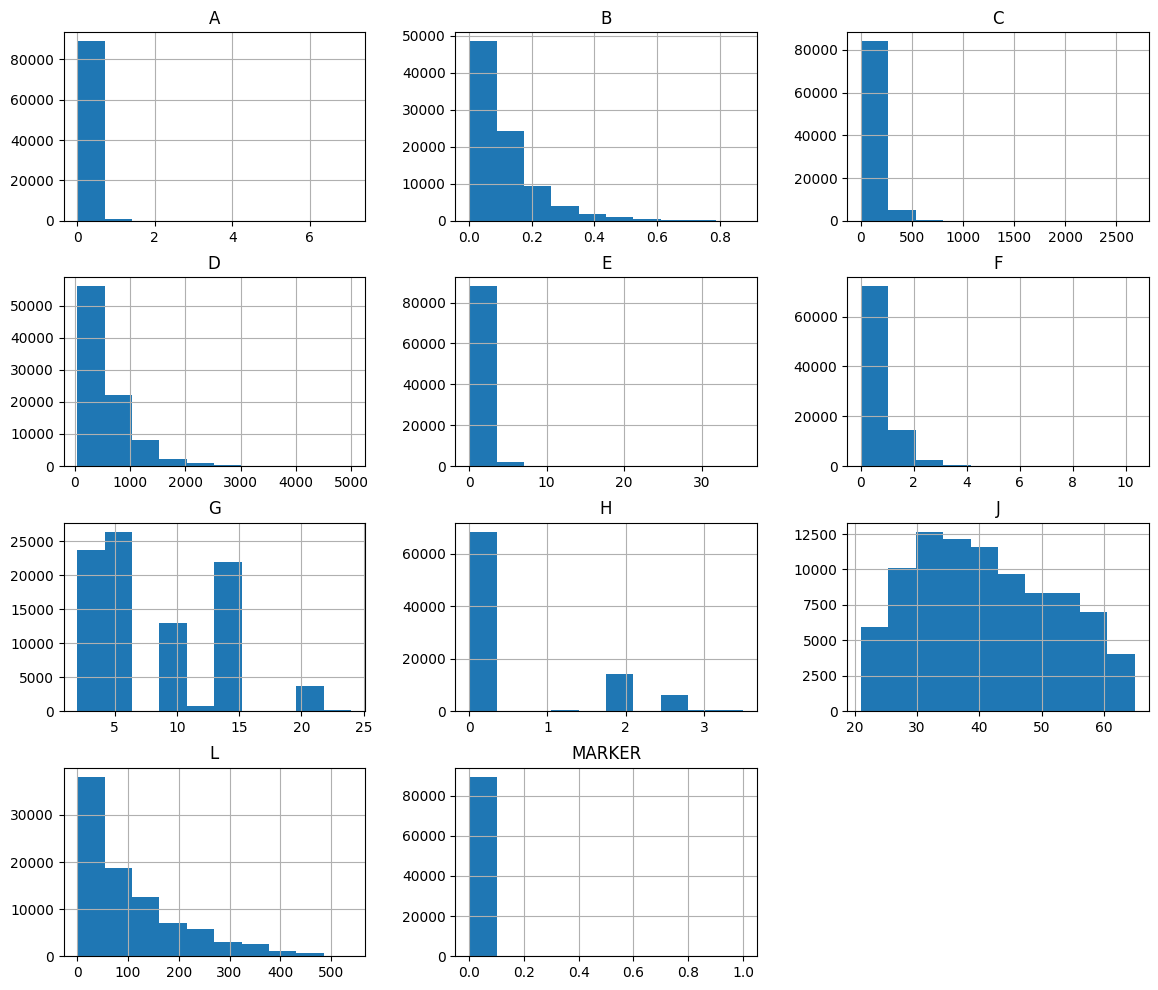

In [10]:
df_train.drop(columns='ID', axis=1).hist(figsize=(14, 12))

### Вывожу количество уникальных значений и их долю от суммы всех значений в категориальных столбцах

In [11]:
for property in ['Sex', 'Region', 'Job_title', 'Education', 'Marriage', 'Property', 'Employment_status']:
    print(df_train[property].value_counts(), df_train[property].value_counts() / df_train.shape[0], sep='\n\n', end='\n\n')
    print('-' * 100)

Sex
Woman    48996
Man      40738
Name: count, dtype: int64

Sex
Woman    0.546014
Man      0.453986
Name: count, dtype: float64

----------------------------------------------------------------------------------------------------
Region
Minsk region      15274
Minsk             14012
Brest region      13897
Grodno region     12614
Vitebsk region    12560
Gomel region      12493
Mogilev region     8884
Name: count, dtype: int64

Region
Minsk region      0.170214
Minsk             0.156150
Brest region      0.154869
Grodno region     0.140571
Vitebsk region    0.139969
Gomel region      0.139223
Mogilev region    0.099004
Name: count, dtype: float64

----------------------------------------------------------------------------------------------------
Job_title
NE employee                    72475
Head/Deputy head (division)     6304
Pensioner                       5951
Enterpreneur                    2725
Head/Deputy head (organiz.)     2279
Name: count, dtype: int64

Job_title
NE employ

### Вывожу и визуализирую распределение значений в столбце с целевой переменной

In [12]:
print(df_train['MARKER'].value_counts(), end='\n\n') 
print(df_train['MARKER'].value_counts() / df_train.shape[0])

MARKER
0    89392
1      342
Name: count, dtype: int64

MARKER
0    0.996189
1    0.003811
Name: count, dtype: float64


Text(0.5, 1.0, 'Marker')

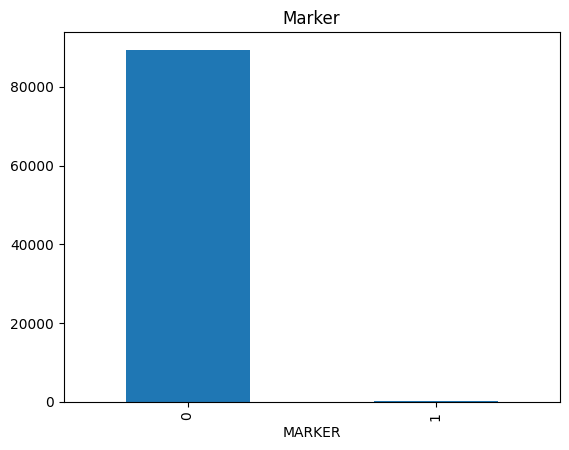

In [13]:
df_train['MARKER'].value_counts().plot(kind='bar')
plt.title('Marker')

In [14]:
print(df_test.MARKER.value_counts(), end='\n\n')
print(df_test.MARKER.value_counts() / df_test.shape[0])

MARKER
0    38259
1      146
Name: count, dtype: int64

MARKER
0    0.996198
1    0.003802
Name: count, dtype: float64


Text(0.5, 1.0, 'Marker')

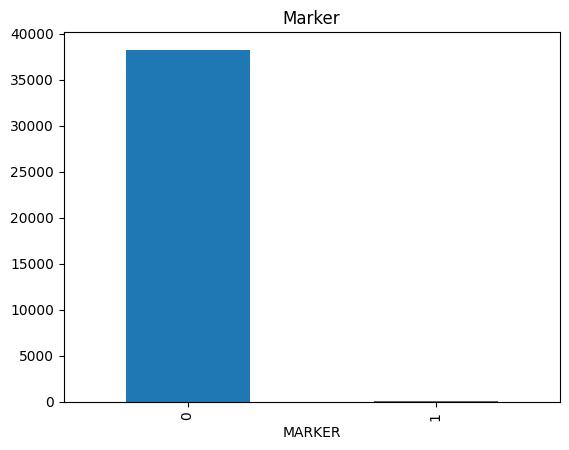

In [15]:
df_test['MARKER'].value_counts().plot(kind='bar')
plt.title('Marker')

### Очевидно, наблюдается сильный дисбаланс классов в столбце с целевой переменной

### Проверяю наличие пропусков в тренировочном и тестовом датасетах

In [16]:
df_train.isna().sum()

ID                   0
A                    0
B                    0
C                    0
D                    0
E                    0
F                    0
G                    0
H                    0
Sex                  0
J                    0
Region               0
L                    0
Job_title            0
Education            0
Marriage             0
Children             0
Property             0
R                    0
Employment_status    0
T                    0
U                    0
V                    0
W                    0
X                    0
MARKER               0
dtype: int64

In [17]:
df_test.isna().sum()

ID                   0
A                    0
B                    0
C                    0
D                    0
E                    0
F                    0
G                    0
H                    0
Sex                  0
J                    0
Region               0
L                    0
Job_title            0
Education            0
Marriage             0
Children             0
Property             0
R                    0
Employment_status    0
T                    0
U                    0
V                    0
W                    0
X                    0
MARKER               0
dtype: int64

### Подготавливаю данные для обучения

In [18]:
# I divide the training and test datasets into features and the target variables
X = df_train.drop(['ID', 'MARKER'], axis=1)
y = df_train['MARKER']
answer = df_test['MARKER']
df_test.drop(['ID', 'MARKER'], axis=1, inplace=True)

In [19]:
# Encoding
X = pd.get_dummies(X, drop_first=True)
df_test = pd.get_dummies(df_test, drop_first=True)

In [20]:
# Check the resulting columns
X.columns.tolist()

['A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'J',
 'L',
 'Sex_Woman',
 'Region_Gomel region',
 'Region_Grodno region',
 'Region_Minsk',
 'Region_Minsk region',
 'Region_Mogilev region',
 'Region_Vitebsk region',
 'Job_title_Head/Deputy head (division)',
 'Job_title_Head/Deputy head (organiz.)',
 'Job_title_NE employee',
 'Job_title_Pensioner',
 'Education_Incomplete higher education',
 'Education_Primary or lower secondary education',
 'Education_Secondary education (plus special education)',
 'Marriage_Divorced/widow',
 'Marriage_Married',
 'Marriage_Single/unmarried',
 'Children_1 One',
 'Children_2 Two',
 'Children_3 Three',
 'Children_More than 3',
 'Property_property',
 'Property_rent/hire',
 'R_Yes',
 'Employment_status_Pensioner',
 'Employment_status_Student',
 'Employment_status_Unemployed',
 'Employment_status_Works',
 'T_Yes',
 'U_Yes',
 'V_No',
 'V_Yes',
 'W_Yes',
 'X_Yes']

### Визуализирую корреляцию признаков

In [21]:
correlation = X.corr()
correlation.style.background_gradient(cmap='coolwarm')

,A,B,C,D,E,F,G,H,J,L,Sex_Woman,Region_Gomel region,Region_Grodno region,Region_Minsk,Region_Minsk region,Region_Mogilev region,Region_Vitebsk region,Job_title_Head/Deputy head (division),Job_title_Head/Deputy head (organiz.),Job_title_NE employee,Job_title_Pensioner,Education_Incomplete higher education,Education_Primary or lower secondary education,Education_Secondary education (plus special education),Marriage_Divorced/widow,Marriage_Married,Marriage_Single/unmarried,Children_1 One,Children_2 Two,Children_3 Three,Children_More than 3,Property_property,Property_rent/hire,R_Yes,Employment_status_Pensioner,Employment_status_Student,Employment_status_Unemployed,Employment_status_Works,T_Yes,U_Yes,V_No,V_Yes,W_Yes,X_Yes
A,1.000000,0.787760,0.279254,0.390606,0.648925,0.473056,-0.324324,-0.229381,0.154316,0.011154,0.149300,0.016255,0.015170,-0.037219,-0.011192,0.024513,-0.004739,-0.051073,-0.016919,-0.051990,0.179834,-0.006163,0.005013,0.069637,0.002221,0.006876,-0.019012,-0.069120,-0.071544,-0.027904,-0.012326,0.040525,-0.028780,-0.034517,0.090146,-0.005758,-0.093160,0.028238,0.037167,-0.009326,0.084198,-0.076897,-0.080715,0.092369
B,0.787760,1.000000,0.282321,0.371655,0.471430,0.657744,-0.317508,-0.212887,0.081070,-0.009512,0.053479,0.022444,0.009723,-0.023171,-0.017510,0.015359,-0.006042,-0.043233,-0.013232,-0.030038,0.123836,0.005617,0.004599,0.059332,0.200160,-0.280887,0.183912,-0.081647,-0.097244,-0.026426,-0.007639,0.006141,-0.013065,-0.053565,0.025072,0.005375,0.058494,-0.306655,0.031703,-0.004206,0.078257,-0.071820,-0.085488,0.081038
C,0.279254,0.282321,1.000000,0.495777,0.318026,0.322362,0.019881,-0.211125,-0.002666,0.011004,-0.048296,0.009919,-0.034060,0.058811,0.003578,0.023828,-0.023780,0.035767,0.048484,-0.053151,-0.020952,0.000166,-0.012127,-0.085327,-0.025228,0.009752,0.009789,-0.017796,-0.010412,-0.008427,-0.004082,0.016871,-0.009459,0.032653,-0.002500,-0.004144,0.006764,0.005782,-0.013914,-0.004304,0.034681,-0.031627,-0.045180,-0.082019
D,0.390606,0.371655,0.495777,1.000000,0.733874,0.702949,0.336855,-0.041913,0.030375,0.032271,-0.037662,0.004560,-0.046608,0.087795,0.014765,0.024001,-0.035309,0.042866,0.059462,-0.055380,-0.030965,-0.000877,-0.007476,-0.070801,-0.029684,0.037277,-0.028963,-0.018335,-0.012231,0.003689,-0.004126,0.035775,-0.021384,0.046840,-0.002467,-0.004682,0.001162,0.034613,-0.007673,-0.000221,0.017212,-0.017723,-0.023294,0.225930
E,0.648925,0.471430,0.318026,0.733874,1.000000,0.782391,0.279598,0.021942,0.113036,-0.006566,0.142138,0.012407,0.011609,-0.032243,-0.021496,0.040214,-0.001851,-0.047668,-0.007088,-0.040594,0.150497,-0.003167,0.008041,0.066227,-0.005840,0.015785,-0.026452,-0.055630,-0.058841,-0.017364,-0.014672,0.037401,-0.024176,-0.029782,0.059443,-0.006253,-0.084032,0.043976,0.024644,-0.006263,0.058683,-0.054196,-0.058909,0.187421
F,0.473056,0.657744,0.322362,0.702949,0.782391,1.000000,0.275341,0.044503,0.042328,-0.027840,0.042214,0.018135,0.006850,-0.019260,-0.027642,0.029893,-0.001798,-0.040214,-0.003594,-0.021675,0.099746,0.008931,0.007186,0.056981,0.192573,-0.272640,0.177479,-0.068677,-0.085851,-0.016672,-0.009440,0.005554,-0.009132,-0.049549,-0.000412,0.004925,0.075702,-0.299199,0.020192,-0.001466,0.051572,-0.047948,-0.064461,0.171696
G,-0.324324,-0.317508,0.019881,0.336855,0.279598,0.275341,1.000000,0.597774,-0.058046,-0.036009,-0.012810,-0.006097,-0.010101,0.004886,-0.013200,0.008231,0.019025,0.002652,0.006956,0.017980,-0.032574,0.008015,0.007184,0.019647,-0.002649,0.002047,-0.007451,0.025944,0.014158,0.016207,0.003105,-0.004767,0.008236,0.004718,-0.035248,-0.000060,0.010776,0.010397,-0.010697,-0.002203,-0.052516,0.046035,0.040366,0.106804
H,-0.229381,-0.212887,-0.211125,-0.041913,0.021942,0.044503,0.597774,1.000000,-0.062062,-0.046920,-0.003752,-0.001776,-0.008228,-0.044233,-0.017166,-0.022835,0.067950,-0.029315,-0.025651,0.058586,-0.020049,0.010949,0.018608,0.108377,0.027386,-0.038627,0.016588,0.031663,0.010871,0.017250,0.008316,-0.023999,0.023077,-0.013594,-0.028798,0.001449,-

### Наблюдается сильная корреляция между признаками A, B, D, E, F, при этом неизвестно, являются они зависимыми или нет. Чтобы избежать мультиколлинеарности, я удалю все перечисленные признаки, кроме одного

In [22]:
X.drop(['B', 'D', 'E', 'F'], axis=1, inplace=True)
df_test.drop(['B', 'D', 'E', 'F'], axis=1, inplace=True)

### Строю новую матрицу корреляции, проверяю отсутствие сильной корреляции между независимыми переменными или переменными, информация о сути которых отсутствует

In [23]:
correlation = X.corr()
correlation.style.background_gradient(cmap='coolwarm')

,A,C,G,H,J,L,Sex_Woman,Region_Gomel region,Region_Grodno region,Region_Minsk,Region_Minsk region,Region_Mogilev region,Region_Vitebsk region,Job_title_Head/Deputy head (division),Job_title_Head/Deputy head (organiz.),Job_title_NE employee,Job_title_Pensioner,Education_Incomplete higher education,Education_Primary or lower secondary education,Education_Secondary education (plus special education),Marriage_Divorced/widow,Marriage_Married,Marriage_Single/unmarried,Children_1 One,Children_2 Two,Children_3 Three,Children_More than 3,Property_property,Property_rent/hire,R_Yes,Employment_status_Pensioner,Employment_status_Student,Employment_status_Unemployed,Employment_status_Works,T_Yes,U_Yes,V_No,V_Yes,W_Yes,X_Yes
A,1.000000,0.279254,-0.324324,-0.229381,0.154316,0.011154,0.149300,0.016255,0.015170,-0.037219,-0.011192,0.024513,-0.004739,-0.051073,-0.016919,-0.051990,0.179834,-0.006163,0.005013,0.069637,0.002221,0.006876,-0.019012,-0.069120,-0.071544,-0.027904,-0.012326,0.040525,-0.028780,-0.034517,0.090146,-0.005758,-0.093160,0.028238,0.037167,-0.009326,0.084198,-0.076897,-0.080715,0.092369
C,0.279254,1.000000,0.019881,-0.211125,-0.002666,0.011004,-0.048296,0.009919,-0.034060,0.058811,0.003578,0.023828,-0.023780,0.035767,0.048484,-0.053151,-0.020952,0.000166,-0.012127,-0.085327,-0.025228,0.009752,0.009789,-0.017796,-0.010412,-0.008427,-0.004082,0.016871,-0.009459,0.032653,-0.002500,-0.004144,0.006764,0.005782,-0.013914,-0.004304,0.034681,-0.031627,-0.045180,-0.082019
G,-0.324324,0.019881,1.000000,0.597774,-0.058046,-0.036009,-0.012810,-0.006097,-0.010101,0.004886,-0.013200,0.008231,0.019025,0.002652,0.006956,0.017980,-0.032574,0.008015,0.007184,0.019647,-0.002649,0.002047,-0.007451,0.025944,0.014158,0.016207,0.003105,-0.004767,0.008236,0.004718,-0.035248,-0.000060,0.010776,0.010397,-0.010697,-0.002203,-0.052516,0.046035,0.040366,0.106804
H,-0.229381,-0.211125,0.597774,1.000000,-0.062062,-0.046920,-0.003752,-0.001776,-0.008228,-0.044233,-0.017166,-0.022835,0.067950,-0.029315,-0.025651,0.058586,-0.020049,0.010949,0.018608,0.108377,0.027386,-0.038627,0.016588,0.031663,0.010871,0.017250,0.008316,-0.023999,0.023077,-0.013594,-0.028798,0.001449,-0.001115,-0.021912,-0.002557,-0.013960,-0.075442,0.067150,0.055485,-0.105762
J,0.154316,-0.002666,-0.058046,-0.062062,1.000000,0.408005,0.209313,-0.003100,-0.009376,0.002193,0.002476,0.016102,0.015643,0.012275,0.024101,-0.283776,0.435952,-0.090324,0.015090,0.113595,0.210148,0.030647,-0.244679,-0.220086,-0.205190,-0.070231,-0.016185,0.196384,-0.089327,-0.048742,0.347371,-0.034462,-0.214973,0.018130,0.173331,-0.031355,0.031730,-0.033154,0.051991,0.043696
L,0.011154,0.011004,-0.036009,-0.046920,0.408005,1.000000,0.104807,0.016843,0.018911,-0.048925,0.005651,0.010853,0.005834,0.058077,-0.003075,0.023461,-0.067864,-0.049506,-0.003636,0.039583,0.066486,0.052255,-0.129179,-0.072677,-0.069217,-0.028474,-0.010503,0.096936,-0.045886,-0.015714,0.081927,-0.017922,-0.096078,0.075928,0.104616,0.016369,-0.032134,0.029440,0.073748,0.017727
Sex_Woman,0.149300,-0.048296,-0.012810,-0.003752,0.209313,0.104807,1.000000,-0.009010,-0.008656,-0.015770,-0.006898,0.018527,0.025422,-0.025317,-0.040457,-0.027336,0.139304,-0.006715,-0.010795,-0.035581,0.208570,-0.159430,0.004697,-0.039071,-0.111873,-0.073068,-0.034264,0.047522,-0.025815,-0.158955,0.042189,-0.022591,-0.296222,0.032770,0.061482,-0.004689,0.013755,-0.014618,-0.011873,0.005638
Region_Gomel region,0.016255,0.009919,-0.006097,-0.001776,-0.003100,0.016843,-0.009010,1.000000,-0.162649,-0.173001,-0.182148,-0.133313,-0.162244,-0.011545,-0.007016,-0.001238,0.017657,-0.008853,0.006079,-0.019136,0.011186,-0.011015,-0.005567,0.007096,0.002199,-0.013991,-0.004912,0.072462,-0.007175,-0.070720,0.003987,0.000108,0.019296,-0.024632,-0.001163,0.090833,-0.080104,0.075990,-0.031797,-0.003011
Region_Grodno region,0.015170,-0.034060,-0.010101,-0.008228,-0.009376,0.018911,-0.008656,-0.162649,1.000000,-0.173973,-0.183171,-0.134062,-0.163156,-0.007045,-0.014339,0.014571,-0.003935,-0.00

In [24]:
# Так как наблюдается сильный дисбаланс классов в целевой переменной, с помощью метода SMOTE я избавляюсь от дисбаланса и затем разделяю данные для обучения и тестирования
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [25]:
# Проверяю распределение в целевой переменной после применения метода SMOTE
y_train_resampled.value_counts()

MARKER
0    71504
1    71504
Name: count, dtype: int64

## CatBoostClassifier

### Создаю и обучаю модель в первом приближении

In [26]:
catboost_model_1 = CatBoostClassifier(
    iterations=100,
    learning_rate=0.1,
    depth=6,
	 eval_metric='AUC:hints=skip_train~false'
)

In [27]:
catboost_model_1.fit(X_train_resampled, y_train_resampled,
				eval_set=(X_test, y_test),
            verbose=False,
            plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

### Делаю предсказание с помощью обученной модели и оцениваю качество моодели

In [28]:
result_1 = catboost_model_1.predict(df_test)

In [30]:
roc_auc_score(answer, catboost_model_1.predict(df_test))

0.7308330531593068

In [31]:
confusion_matrix(answer, result_1)

array([[34696,  3563],
       [   65,    81]], dtype=int64)

### Провожу тюнинг гиперпараметров и кросс-валидацию с помощью функции grid_search из библиотеки CatBoost

In [32]:
catboost_model_2 = CatBoostClassifier(eval_metric='AUC:hints=skip_train~false',
												  logging_level='Silent')

grid_params = {'learning_rate': [0.01, 0.05, 0.1, 0.3, 0.5, 0.7, 0.9],
               'iterations': [50, 100, 200, 400],
					'depth': [4, 6, 8, 10]}


catboost_model_2.grid_search(grid_params,
                             X_train,
									  y_train,
									  cv=5,
									  plot=True,
									  verbose=False,
									  refit=True
                                          )['params']

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

{'depth': 6, 'iterations': 50, 'learning_rate': 0.5}

### Делаю предсказание и вычисляю точность для оптимизированной модели

In [33]:
roc_auc_score(y_test, catboost_model_2.predict(X_test))

0.5084186728722598

In [34]:
confusion_matrix(y_test, catboost_model_2.predict(X_test))

array([[17886,     2],
       [   58,     1]], dtype=int64)

## RandomForestClassifier

### Создаю и обучаю модель RandomForestClassifier в первом приближении

In [35]:
model_rfc_1 = RandomForestClassifier()
model_rfc_1.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier()

In [36]:
result_rfc_1 = model_rfc_1.predict(df_test)
roc_auc_score(answer, result_rfc_1)

0.5032939693301639

### Провожу тюнинг глобальных параметров и кросс-валидацию с помощью функции GridSearchCV библиотеки sklearn

In [40]:
param_grid = {
		'n_estimators': [100, 200, 300, 400],
      'max_depth': [6, 7, 8]
}

In [41]:
grid_search_res = GridSearchCV(model_rfc_1, param_grid = param_grid, error_score='raise')

In [42]:
grid_search_res.fit(X_train_resampled, y_train_resampled).best_params_
grid_search_res.best_params_

{'max_depth': 8, 'n_estimators': 100}

In [43]:
result_rfc_2 = grid_search_res.predict(df_test)
roc_auc_score(answer, result_rfc_2)

0.6593577050721703

In [44]:
# 22 - Define base models with tuned hyperparameters
base_models = [
    ('catboost', CatBoostClassifier(
    iterations=100,
    learning_rate=0.1,
    depth=6,
    random_state=42
    )),
    ('xgboost', XGBClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=6,
        random_state=42
    )),
    ('lightgbm', LGBMClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=6,
        random_state=42
    ))
]

In [45]:
# 23 - Defining the meta-model with tuned hyperparameters
meta_model = CatBoostClassifier(
    iterations=100,
    learning_rate=0.1,
    depth=6,
    random_state=42
)

In [46]:
# 24 - Creating the stacking model
stacking_model=StackingClassifier(estimators=base_models, final_estimator=meta_model, verbose=0)

In [ ]:
# 25 - Fitting the stacking model to the entire training data
stacking_model.fit(X, y)

In [48]:
# 26 - Predict probabilities on the validation set
y_pred_proba_val = stacking_model.predict_proba(X_test)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


In [49]:
y_pred_proba_test = stacking_model.predict_proba(df_test)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


In [50]:
print('Validation ROC AUC Score:', roc_auc_score(y_test, y_pred_proba_val[:, 1]))

Validation ROC AUC Score: 0.9175699645250296


In [51]:
print('Test ROC AUC Score:', roc_auc_score(answer, y_pred_proba_test[:, 1]))

Test ROC AUC Score: 0.8868167647544297


In [52]:
result = stacking_model.predict(df_test)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


In [53]:
roc_auc_score(answer, result)

0.5

In [54]:
confusion_matrix(answer, result)

array([[38259,     0],
       [  146,     0]], dtype=int64)